# Which phone features most significantly influence its price?

## Introduction (250)

People use phones daily, and scholars argue that these devices evolved from luxurious items into necessities over the past years (Tanveer et al.). We use them for "calling and sending messages, capturing pictures, accessing the internet, playing games, socializing, and downloading applications." They turned from mere communication tools into daily "multimedia machines" (Tanveer et al.).

Nevertheless, buying new phones can be challenging and frustrating due to the flood of features they offer (Kobie). To escape this tough choice, consumers usually consider only the advertised characteristics of the device without inquiring whether the phone price corresponds to them (K. Srujan Raju et al. 773). Hence, they are likely to make an uninformed decision and overpay.

Therefore, it is essential to create a **linear regression model that would predict a phone's market price given the device's set of characteristics**. It would help people evaluate whether the phone's proposed price aligns with the competition and is worth paying. 

However, our analysis assumes that the consumer does not have brand loyalty. If they do, our model becomes irrelevant to them because they are willing to pay a higher price without considering a cheaper substitution.

Thus, we want our model to help open-minded consumers quickly yet critically evaluate a phone's price tag and make a rational purchasing decision without being misled by advertising.

## Data set and Methods (300)

We use a data set containing specifications and prices for **1321** unique phone models. The researchers collected the observations via scraping [gadgets360.com](https://www.gadgets360.com/mobiles/best-phones) - an Indian tech news website - and published the [data set](https://www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices) in **2022** (Garai). 

Therefore, the data for our study is reliable and reasonably recent. Nevertheless, our analysis assumes that phone prices in the Indian market correspond to those in other countries, but it's not always the case. For example, iPhone prices in the US are significantly lower (Hilsenteger), so our data may only partially reflect the global market prices.

Here's the list of variables we will consider in our analysis. We rename them from the original data set, derive `resolution` from another two variables, and convert `price` from Indian Rupee to US Dollar to ease the investigation.

| Variable Name  | Description                                                 |
| -------------- | ----------------------------------------------------------- |
| `price`        | Phone price in USD                                          |
| `battery`      | Battery capacity in mAh                                     |
| `screen_size`  | Screen Size in Inches across opposite corners               |
| `touchscreen`  | Whether the phone is touchscreen supported or not           |
| `resolution`   | The resolution of the phone: (width $\times$ height) / 1000 |
| `processor`    | Number of processor cores                                   |
| `ram`          | RAM available in phone in GB                                |
| `storage`      | Internal Storage of phone in GB                             |
| `rear_camera`  | Resolution of rear camera in MP (0 if unavailable)          |
| `front_camera` | Resolution of front camera in MP (0 if unavailable)         |
| `os`           | Operating system used in phone                              |
| `gps`          | Whether phone has GPS functionality                         |
| `num_of_sims`  | Number of SIM card slots in phone                           |
| `x3g`          | Whether phone has 3G network functionality                  |
| `x4g_lte`      | Whether phone has 4G/LTE network functionality              |

We plan to create multiple linear regression models and assess their performance to choose the best one for this data. Specifically, we'll perform these steps:

#### 1. Preliminary Analysis:
- Read and wrangle the data
- Calculate summary statistics and visualize the association between `price` and other variables

#### 2. Models' Creation:
- Split the data into testing and training sets, **70% being the training set**
- Deal with possible multicollinearity between the input variables by:
    - Using **Variance Inflation Factor** (VIF) to detect it
    - Dropping highly correlated variables if it is present
- Create a **simple linear regression** model
- Create several **multiple linear regression** models using:
    - All variables as predictors for `price`
    - Stepwise variable selection with **backward selection**
    - Smooth variable selection with **LASSO**

#### 3. Models' Evaluation:
- Assess the performance of the models using **Mean Squared Error** (MSE)

## Preliminary Analysis (150)

Here's the code for performing the first point from the list above.

In [1]:
# Installing missing packages
# https://stackoverflow.com/a/4090208/18184038
package_list <- "psych"
to_install <- package_list[!(package_list %in% installed.packages()[, "Package"])]
if (length(to_install)) install.packages(to_install)

**(!!! change URL to the data set on the main branch)**

In [2]:
library(tidyverse)
library(psych)
library(GGally)
library(broom)
library(car)

set.seed(1)

# Reading the data set from the web
url <- "https://raw.githubusercontent.com/Ihor16/stat-301-project/ih/rewrite_for_new_dataset/data/specs.csv"
data_raw <- read.csv(url) %>%
  as_tibble()

# Previewing the raw data set
data_raw %>%
  head(3)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:psych’:

    logit


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




X,Name,Brand,Model,Battery.capacity..mAh.,Screen.size..inches.,Touchscreen,Resolution.x,Resolution.y,Processor,⋯,Rear.camera,Front.camera,Operating.system,Wi.Fi,Bluetooth,GPS,Number.of.SIMs,X3G,X4G..LTE,Price
<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
0,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,Yes,1440,3120,8,⋯,48,16,Android,Yes,Yes,Yes,2,Yes,Yes,58998
1,Realme X2 Pro,Realme,X2 Pro,4000,6.50,Yes,1080,2400,8,⋯,64,16,Android,Yes,Yes,Yes,2,Yes,Yes,27999
2,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,Yes,1242,2688,6,⋯,12,12,iOS,Yes,Yes,Yes,2,Yes,Yes,106900


In [3]:
# Conversion rate from INR to USD
# https://www.forbes.com/advisor/money-transfer/currency-converter/inr-usd/
rate <- 0.012282

# Renaming the variables and creating a derived variable for `resolution`
phone_data <- data_raw %>%
  select(-c(X, Name, Brand, Model, "Wi.Fi", Bluetooth)) %>%
  rename(
    battery = "Battery.capacity..mAh.",
    screen_size = "Screen.size..inches.",
    touchscreen = "Touchscreen",
    resolution_x = "Resolution.x",
    resolution_y = "Resolution.y",
    processor = "Processor",
    ram = "RAM..MB.",
    storage = "Internal.storage..GB.",
    rear_camera = "Rear.camera",
    front_camera = "Front.camera",
    os = "Operating.system",
    gps = "GPS",
    num_of_sims = "Number.of.SIMs",
    x3g = "X3G",
    x4g_lte = "X4G..LTE",
    price = "Price"
  ) %>%
  mutate(
    price = price * rate,
    resolution = (resolution_x * resolution_y) / 1000,
    ram = ram / 1000
  ) %>%
  relocate(resolution, .before = resolution_x) %>%
  select(-c(resolution_x, resolution_y)) %>%
  drop_na() %>%
  select(price, everything())

# Changing categorical variables to factors
phone_data <- phone_data %>%
  mutate(
    touchscreen = as_factor(touchscreen),
    os = as_factor(os),
    gps = as_factor(gps),
    x3g = as_factor(x3g),
    x4g_lte = as_factor(x4g_lte)
  )

# Previewing the wrangled data set
phone_data %>%
  head()

price,battery,screen_size,touchscreen,resolution,processor,ram,storage,rear_camera,front_camera,os,gps,num_of_sims,x3g,x4g_lte
<dbl>,<int>,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>,<fct>,<fct>
724.6134,4085,6.67,Yes,4492.800,8,12,256,48,16,Android,Yes,2,Yes,Yes
343.8837,4000,6.50,Yes,2592.000,8,6,64,64,16,Android,Yes,2,Yes,Yes
1312.9458,3969,6.50,Yes,3338.496,6,4,64,12,12,iOS,Yes,2,Yes,Yes
772.5378,3110,6.10,Yes,1483.776,6,4,64,12,12,iOS,Yes,2,Yes,Yes
613.9772,4000,6.40,Yes,2527.200,8,6,128,12,32,Android,Yes,1,No,No
429.0103,3800,6.55,Yes,2592.000,8,8,128,48,16,Android,No,2,Yes,Yes


In [4]:
# Disabling scientific notation
# https://stackoverflow.com/a/27318351/18184038
options(scipen = 999)

# Calculating summary statistics for the data set
phone_data %>%
  describe() %>%
  select(min, mean, median, max, sd)

,min,mean,median,max,sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
price,6.067308,140.823270,85.96172,2149.227,170.1977791
battery,1010.000000,2938.489330,3000.00000,6000.000,873.5141331
screen_size,2.400000,5.291310,5.20000,7.300,0.6713566
touchscreen*,1.000000,1.012509,1.00000,2.000,0.1111837
resolution,76.800000,1348.761263,921.60000,8294.400,954.7353441
processor,1.000000,5.551141,4.00000,10.000,2.1965624
ram,0.064000,2.488778,2.00000,12.000,1.6644404
storage,0.064000,30.654864,16.00000,512.000,36.9502412
rear_camera,0.000000,12.070199,12.20000,108.000,8.9483374


Scholars argue that `ram`, `storage`, and `resolution` are the most significant factors influencing a phone's price (Listianingrum et al.). We can check if our data reflects this by finding the correlation of each numerical variables with `price`.

In [5]:
# Selecting only numeric variables
phone_data_numeric <- phone_data %>%
  select_if(is.numeric)

# Calculating correlation between `price` and every other variable
# https://stackoverflow.com/a/45892364/18184038
phone_data_corr <- cor(phone_data_numeric[-1], phone_data_numeric$price) %>%
  as.data.frame() %>%
  rename(correlation = V1)

phone_data_corr %>%
  arrange(desc(correlation))

,correlation
,<dbl>
storage,0.6440791
ram,0.6134463
resolution,0.5934752
screen_size,0.4024624
rear_camera,0.3791199
front_camera,0.3106717
processor,0.3024918
battery,0.2975252
num_of_sims,-0.1624911


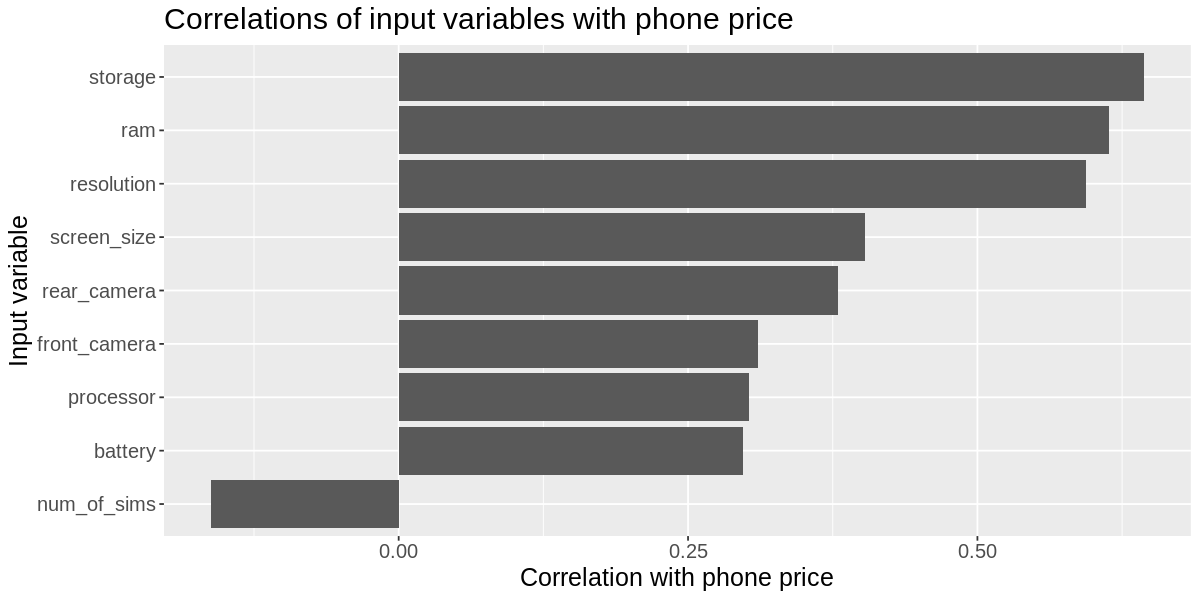

In [6]:
options(repr.plot.width = 10, repr.plot.height = 5)

# Plotting the distribution of calculated correlation coefficients
tibble(
  correlation = phone_data_corr$correlation,
  name = phone_data_numeric[-1] %>% colnames()
) %>%
  ggplot(aes(x = reorder(name, correlation), y = correlation)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Correlations of input variables with phone price",
    x = "Input variable",
    y = "Correlation with phone price"
  ) +
  theme(
    text = element_text(size = 15)
  ) +
  coord_flip()

The data shows that these variables are indeed the top 3 ones correlated with `price`, so the initial analysis of the data corresponds to scholarly claims and we expect these variables to be present in our final predictive model.

However, the correlation coefficients for these top 3 variables are below 0.7. This moderate correlation suggests that there may be important factors influencing the phone's price among the categorical variables, which we skipped here. Therefore, it's worth conducting a more rigorous analysis to find the variables significantly associated with `price`.

## Analysis (1000)

#### Multicollinearity check

!!! explain why multicollinearity is not desirable

!!! create a heat map plot

In [7]:
# Creating a correlation matrix for all numeric variables
phone_data_corr_matrix <- phone_data_numeric %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

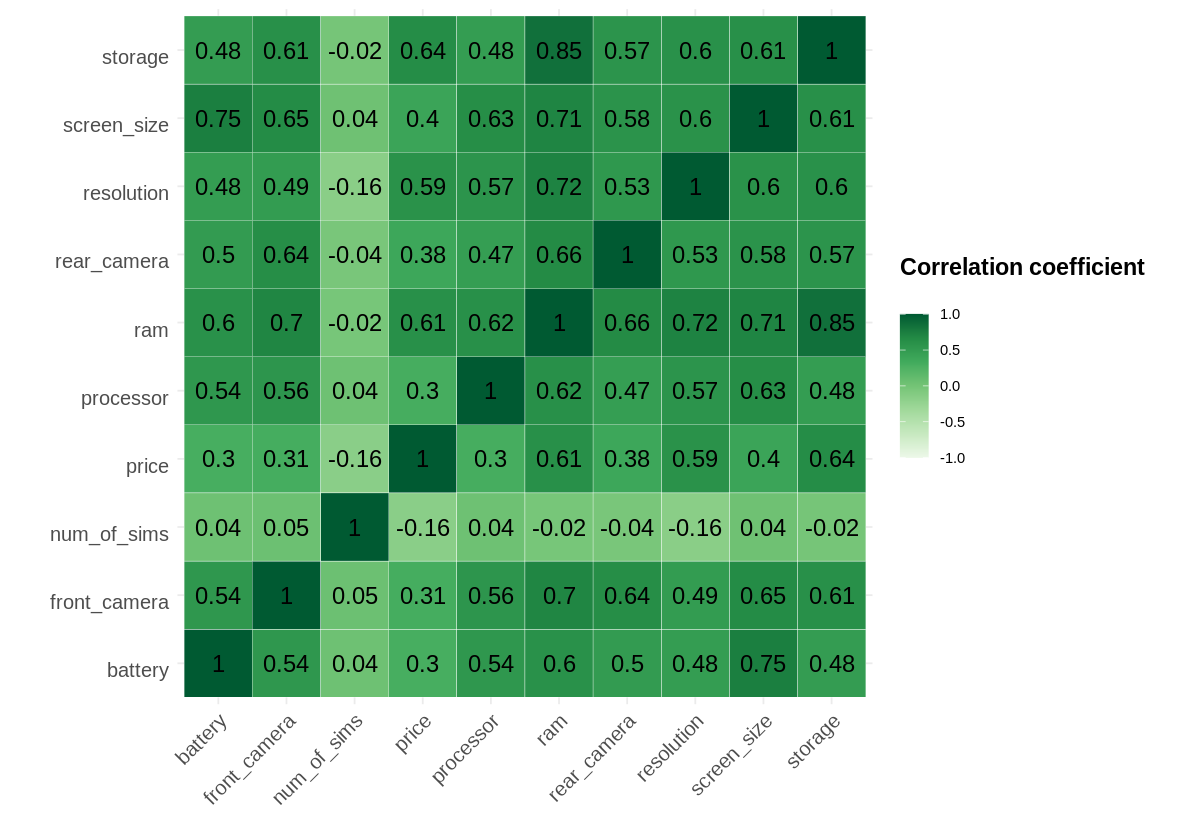

In [8]:
options(repr.plot.width = 10, repr.plot.height = 7)

phone_data_corr_matrix %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller(
    "Correlation coefficient \n",
    palette = "Greens",
    direction = 1,
    limits = c(-1, 1)
  ) +
  theme_minimal() +
  labs(x = "", y = "") +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 12, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 12, hjust = 1
    ),
    legend.title = element_text(size = 14, face = "bold")
  ) +
  coord_fixed() +
  geom_text(aes(x = var1,
                y = var2,
                label = round(corr, 2)),
            color = "black",
            size = 5
  )

!!! explain the plot

!!! start rigorously calculating multicollinearity using VIF

!!! split the data first

In [9]:
# Adding `ID` column to the full data set
phone_data$ID <- rownames(phone_data)

# (1) Shuffling the original data set
# (2) Selecting 70% of the observations
# (3) Assigning those to the training data set
phone_training <- phone_data %>%
  sample_n(size = nrow(phone_data) * 0.7)

# Assigning the rest 30% of the observations to the testing set
phone_testing <- anti_join(
  x = phone_data,
  y = phone_training,
  by = "ID"
)

# Dropping the `ID` column from the created data sets
phone_training <- phone_training %>%
  select(-ID)
phone_testing <- phone_testing %>%
  select(-ID)

# Calculating number of observations in training and testing sets
tibble(
  data_set = c("training_data", "testing_data"),
  num_of_obs = c(phone_training %>% nrow(), phone_testing %>% nrow())
)

data_set,num_of_obs
<chr>,<int>
training_data,951
testing_data,408


!!! calculating VIF

In [10]:
# Creates MRL for the `data_set` and calculates its VIF
calculate_vif <- function(data_set) {
  # Creating a multiple linear regression using all input variables from the given data set
  mlr <- data_set %>%
    lm(formula = price ~ .)

  # Using Variance Inflation Factor (VIF) to quantify the possible multicollinearity
  mlr %>%
    vif() %>%
    as.data.frame() %>%
    round(3) %>%
    arrange(desc(GVIF)) %>% 
    head(10)
}

In [11]:
# Calculating VIF for training data's MLR will all input variables
calculate_vif(phone_training)

,GVIF,Df,GVIF^(1/(2*Df))
,<dbl>,<dbl>,<dbl>
ram,6.446,1,2.539
screen_size,3.816,1,1.953
storage,3.628,1,1.905
resolution,2.523,1,1.588
battery,2.515,1,1.586
front_camera,2.492,1,1.579
rear_camera,2.085,1,1.444
processor,2.060,1,1.435
x4g_lte,1.421,1,1.192


!!! playing with different variable selections

In [12]:
# Calculating VIF for training data's MLR without `ram`
calculate_vif(phone_training %>% select(-ram))

# Calculating VIF for training data's MLR without `ram` and `storage`
calculate_vif(phone_training %>% select(-c(storage, ram)))

# Adjusting `ram` column to indicate how much a phone's ram capacity is above the average one
phone_adjusted_ram <- phone_training %>%
  mutate(ram = ram - 4)

# Calculating VIF for MLR of the adjusted training data set
calculate_vif(phone_adjusted_ram)

,GVIF,Df,GVIF^(1/(2*Df))
,<dbl>,<dbl>,<dbl>
screen_size,3.795,1,1.948
battery,2.503,1,1.582
front_camera,2.432,1,1.560
resolution,2.221,1,1.490
storage,2.088,1,1.445
processor,2.022,1,1.422
rear_camera,2.018,1,1.421
os,1.400,5,1.034
x4g_lte,1.379,1,1.174


,GVIF,Df,GVIF^(1/(2*Df))
,<dbl>,<dbl>,<dbl>
screen_size,3.683,1,1.919
battery,2.502,1,1.582
front_camera,2.300,1,1.516
resolution,2.033,1,1.426
processor,2.021,1,1.422
rear_camera,1.972,1,1.404
os,1.388,5,1.033
x4g_lte,1.374,1,1.172
x3g,1.319,1,1.149


,GVIF,Df,GVIF^(1/(2*Df))
,<dbl>,<dbl>,<dbl>
ram,6.446,1,2.539
screen_size,3.816,1,1.953
storage,3.628,1,1.905
resolution,2.523,1,1.588
battery,2.515,1,1.586
front_camera,2.492,1,1.579
rear_camera,2.085,1,1.444
processor,2.060,1,1.435
x4g_lte,1.421,1,1.192


!!! will keep `ram` because scholars say it's an important predictor

## Evaluation (300)

Our analysis has multiple crucial limitations that may hinder its findings.

1. The smartphone market is quickly evolving, so even though the data set was published in 2022, it misses variables describing critical features of modern smartphones. For instance, the data does not have variables for NFS module or 5G compatibility, which may influence smartphone prices today.

## Conclusion (200)

## References

“Best Mobile Phones in India | Latest & New Smartphones Price.” *Gadgets 360*, 2020, www.gadgets360.com/mobiles/best-phones. Accessed 3 Dec. 2022.

Garai, Pratik. “Mobile Phone Specifications and Prices.” *Www.kaggle.com*, 14 Aug. 2022, www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices. Accessed 4 Dec. 2022.

Hilsenteger, Lewis. “IPhone 14 ESIM Controversy Explained.” *Www.youtube.com*, 12 Sept. 2022, www.youtube.com/watch?t=543&v=DLILlKdELEk&feature=youtu.be. Accessed 3 Dec. 2022.

K. Srujan Raju, et al. *Data Engineering and Communication Technology*. Springer, 9 Jan. 2020, p. 773.

Kobie, Nicole. “Why Does Buying a New Phone Have to Be so - ProQuest.” *Www.proquest.com*, Apr. 2017, www.proquest.com/docview/1985885659?accountid=14656&forcedol=true&pq-origsite=summon. Accessed 3 Dec. 2022.

Listianingrum, T, et al. “Smartphone Hedonic Price Study Based on Online Retail Price in Indonesia.” *Journal of Physics: Conference Series*, vol. 1863, no. 1, 1 Mar. 2021, p. 012032, 10.1088/1742-6596/1863/1/012032. Accessed 1 May 2022.

Tanveer, Muhammad, et al. “Mobile Phone Buying Decisions among Young Adults: An Empirical Study of Influencing Factors.” *Sustainability*, vol. 13, no. 19, 27 Sept. 2021, p. 10705, 10.3390/su131910705. Accessed 8 Oct. 2021.